In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
from tqdm import notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split 

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [5]:
ids = next(os.walk("train/images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [6]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [7]:
X.shape, y.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

#### Load the images and masks into arrays

In [9]:
# tqdm is used to display the progress bar
for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("train/images/"+id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("train/masks/"+id_, color_mode = "grayscale"))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

In [10]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Salt')

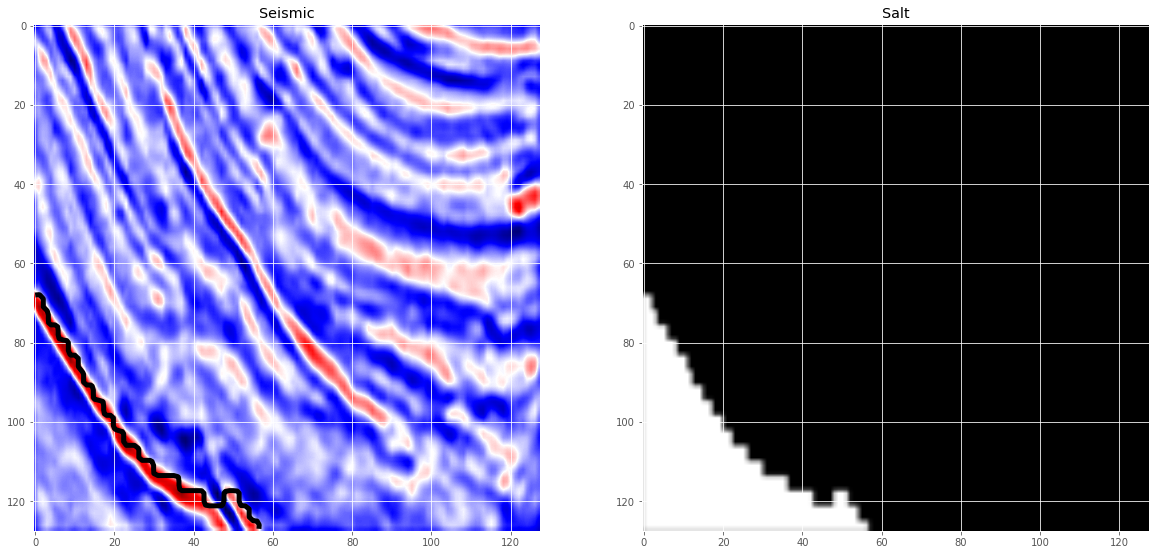

In [11]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [13]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [14]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [17]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3584/3600 [============================>.] - ETA: 0s - loss: 0.4486 - accuracy: 0.8058
Epoch 00001: val_loss improved from inf to 12.06007, saving model to model-tgs-salt.h5
3600/3600 [==============================] - 27s 8ms/sample - loss: 0.4478 - accuracy: 0.8063 - val_loss: 12.0601 - val_accuracy: 0.4092
Epoch 2/50
3584/3600 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8809
Epoch 00002: val_loss improved from 12.06007 to 1.13003, saving model to model-tgs-salt.h5
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.3058 - accuracy: 0.8808 - val_loss: 1.1300 - val_accuracy: 0.7585
Epoch 3/50
3584/3600 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8915
Epoch 00003: val_loss improved from 1.13003 to 0.34043, saving model to model-tgs-salt.h5
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.2674 - accuracy: 0.8914 - val_loss: 0.3404 - val

Epoch 28/50
3584/3600 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9601
Epoch 00028: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00028: val_loss did not improve from 0.13497
3600/3600 [==============================] - 12s 3ms/sample - loss: 0.0808 - accuracy: 0.9602 - val_loss: 0.1492 - val_accuracy: 0.9382
Epoch 00028: early stopping


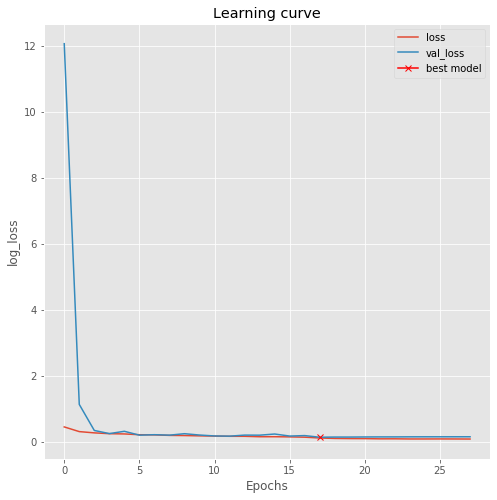

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [19]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [20]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.13496947705745696, 0.9412119]

In [21]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

3600/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

400/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [22]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [23]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

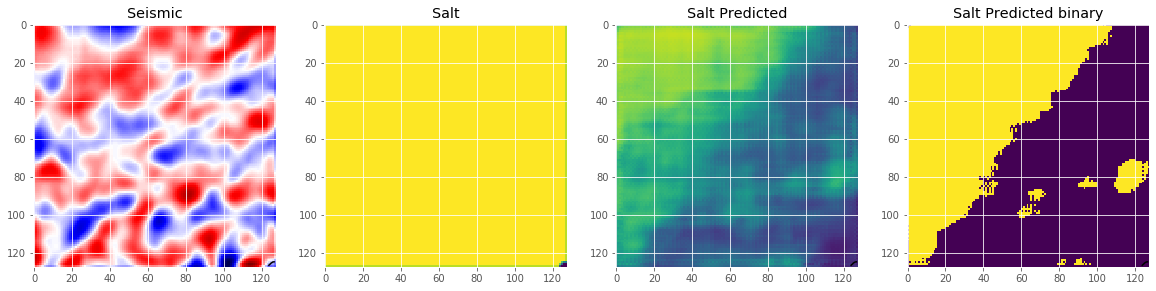

In [24]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

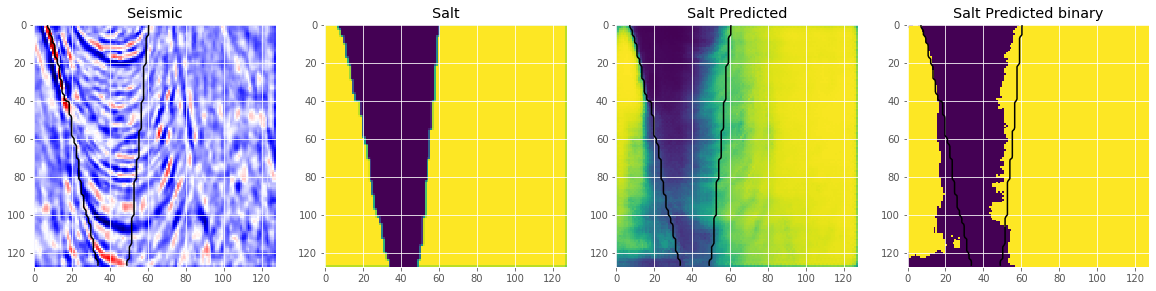

In [25]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

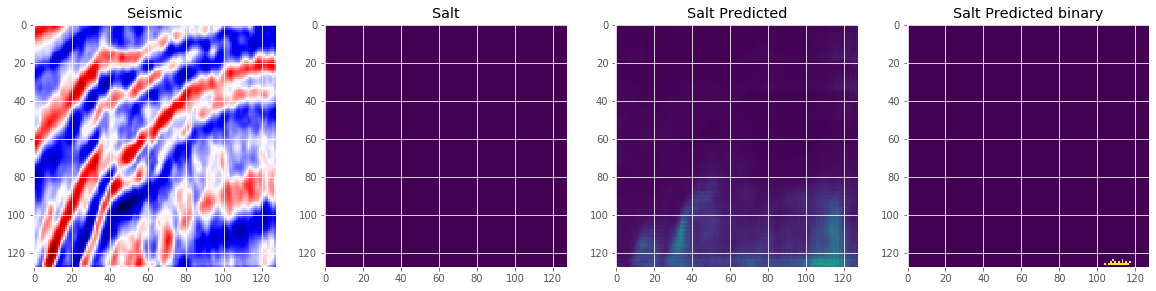

In [26]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

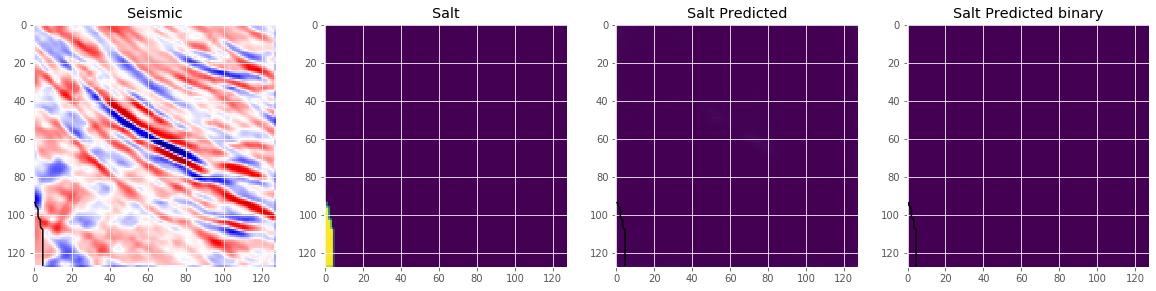

In [27]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

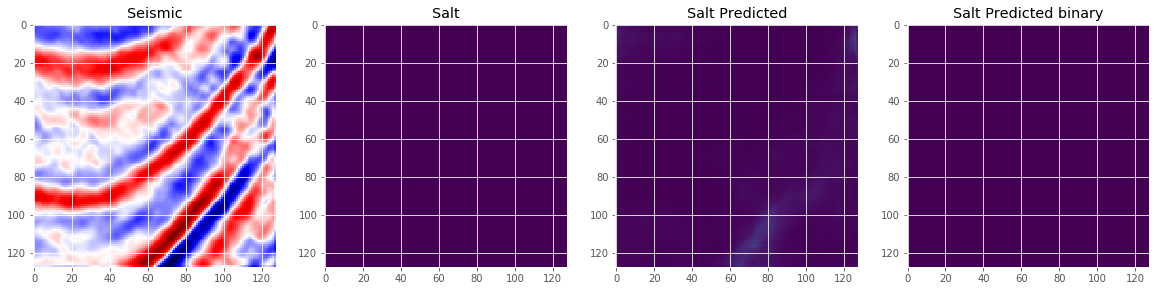

In [28]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

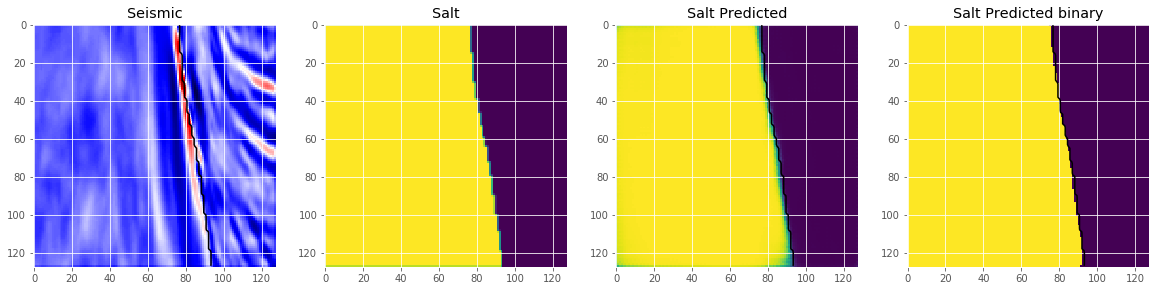

In [29]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

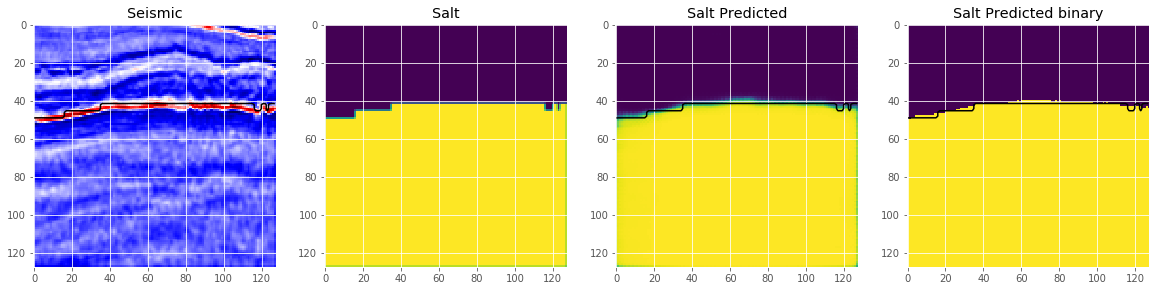

In [30]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

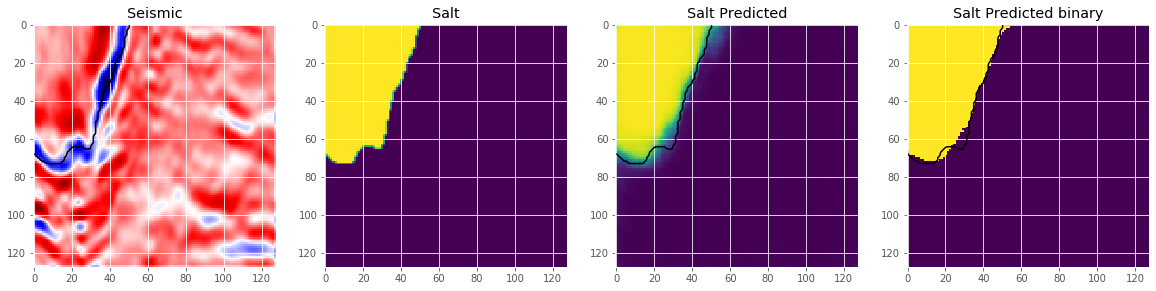

In [31]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

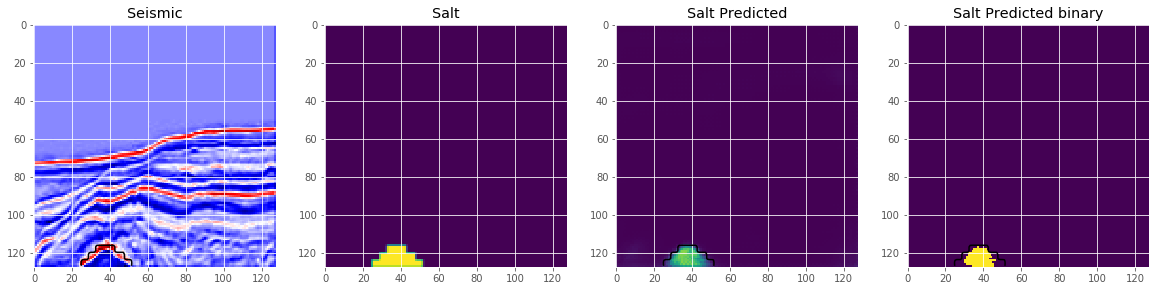

In [32]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

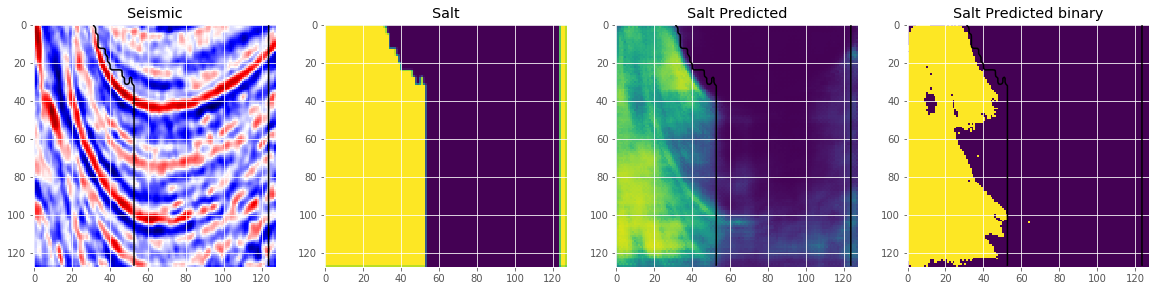

In [33]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

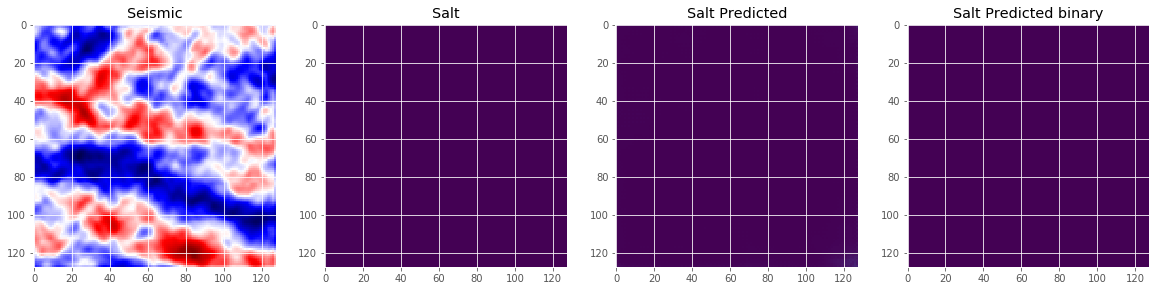

In [34]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

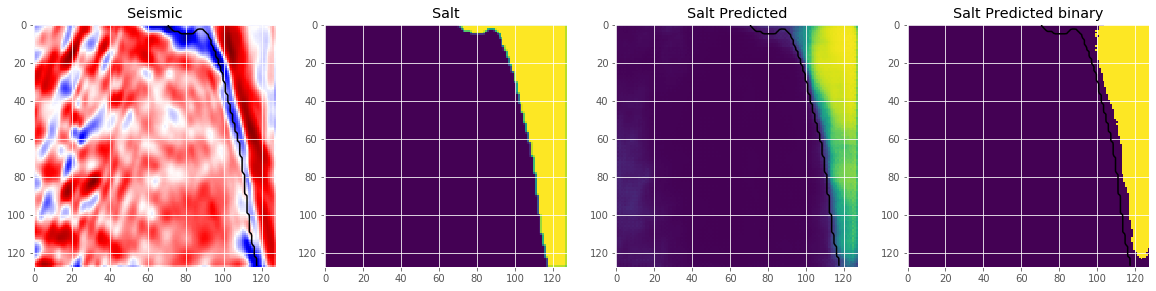

In [35]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

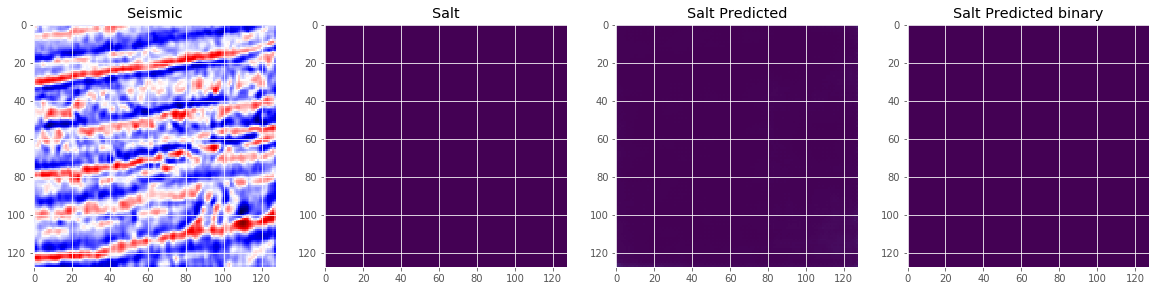

In [36]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

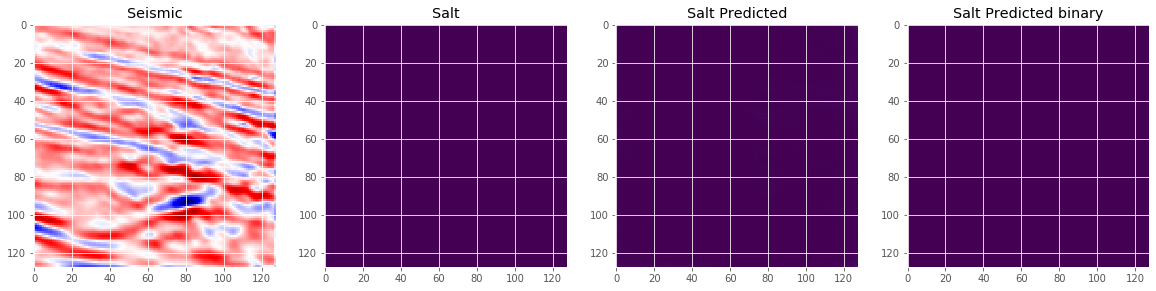

In [37]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

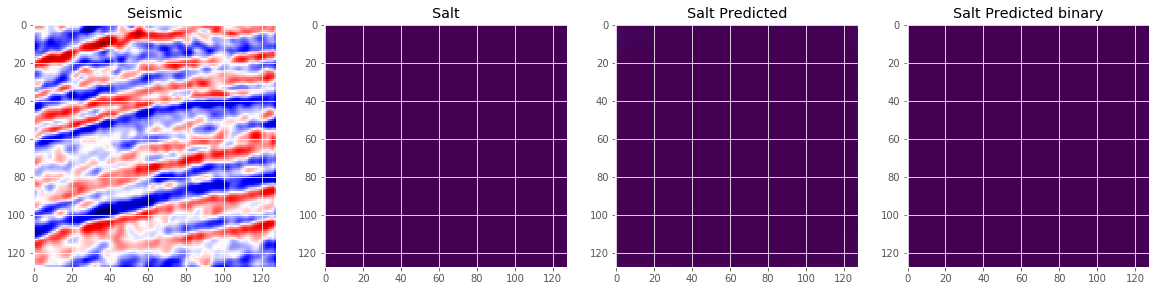

In [38]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

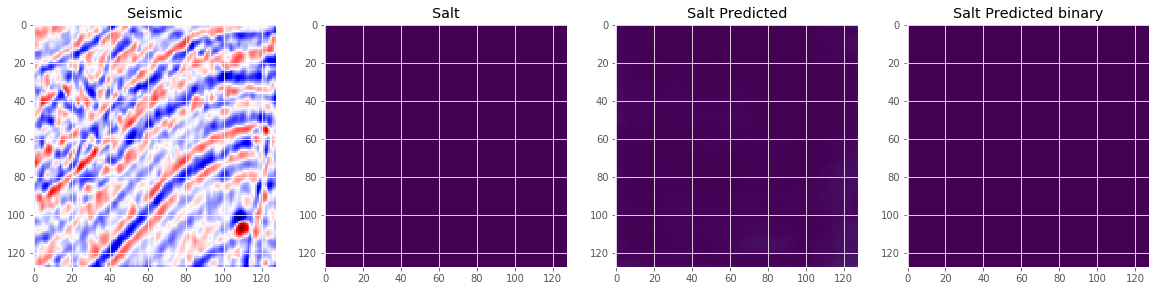

In [39]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

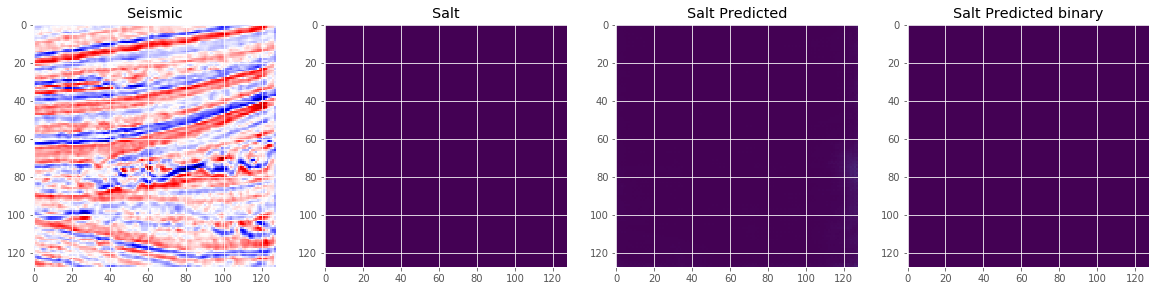

In [40]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

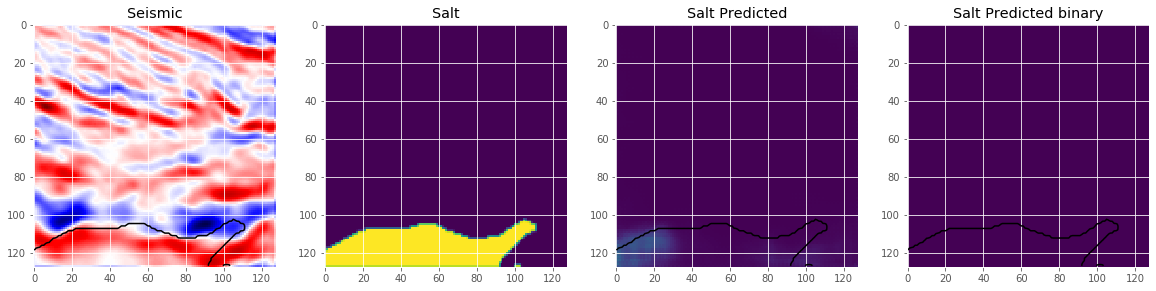

In [41]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

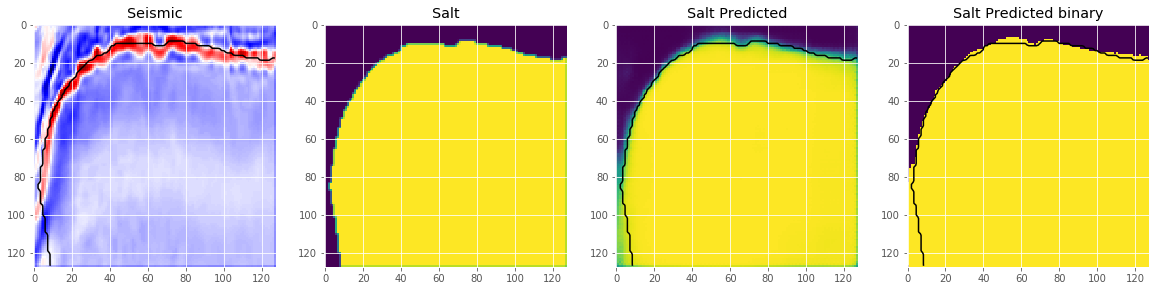

In [42]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

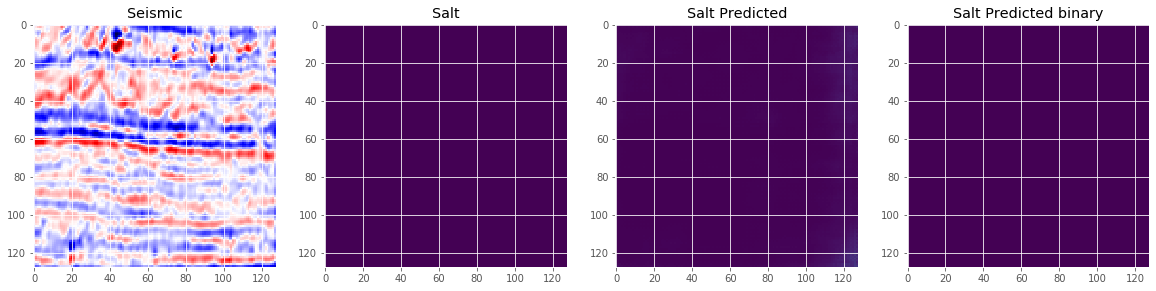

In [43]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

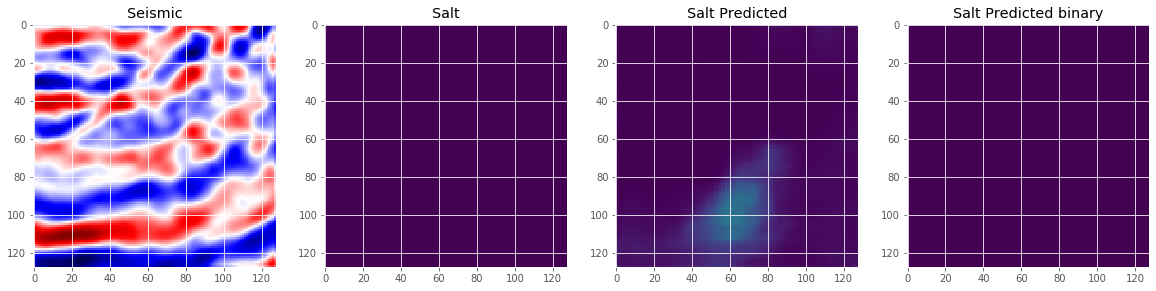

In [44]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

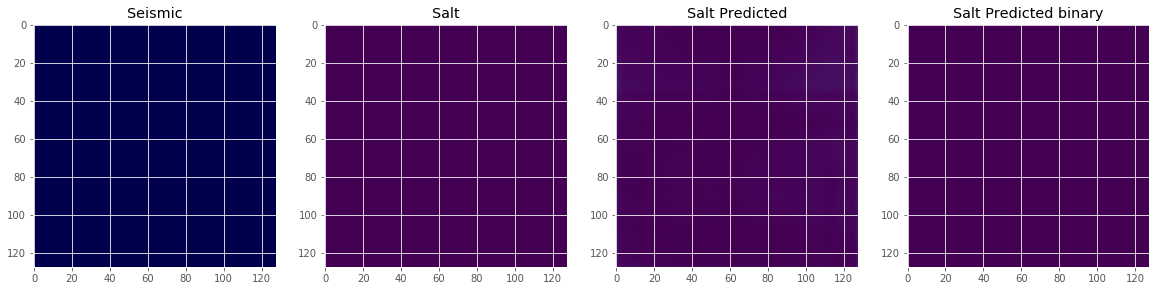

In [45]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

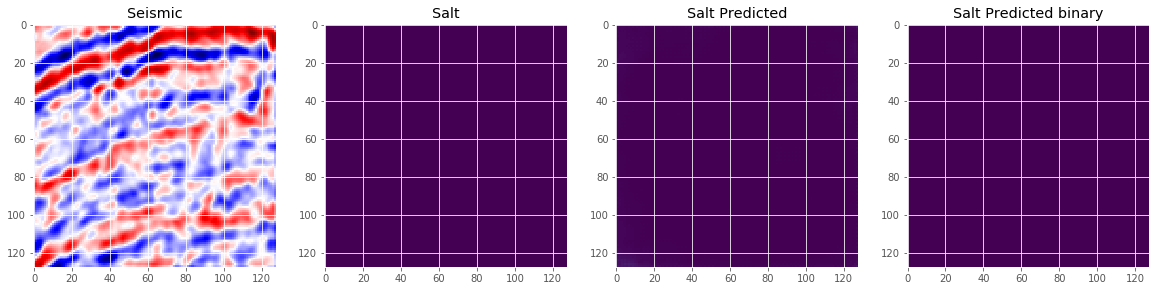

In [46]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

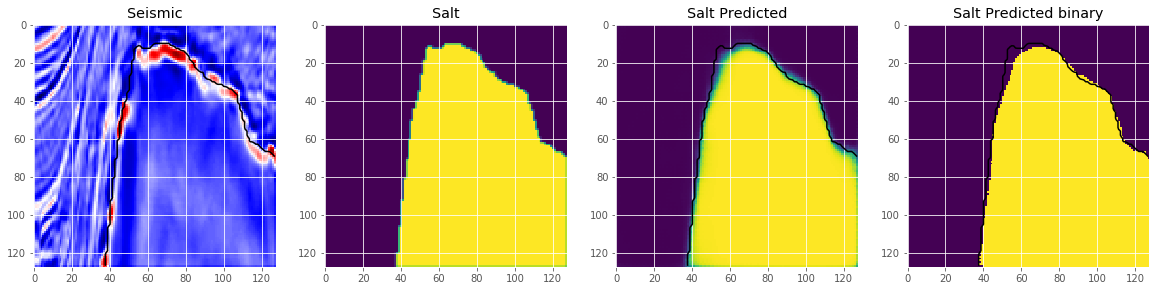

In [47]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

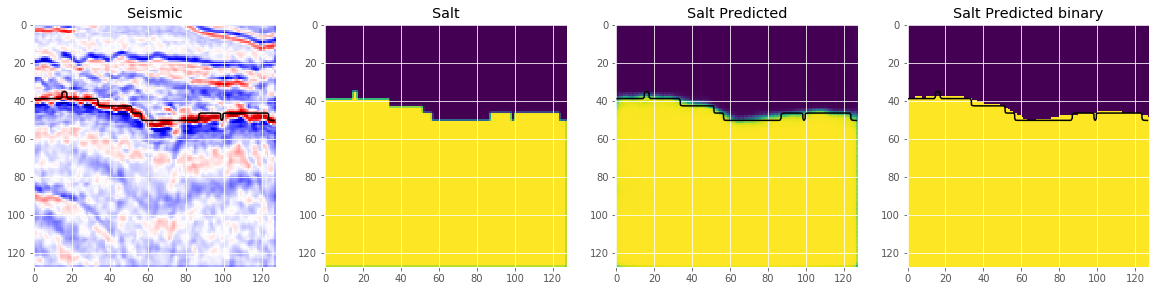

In [48]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

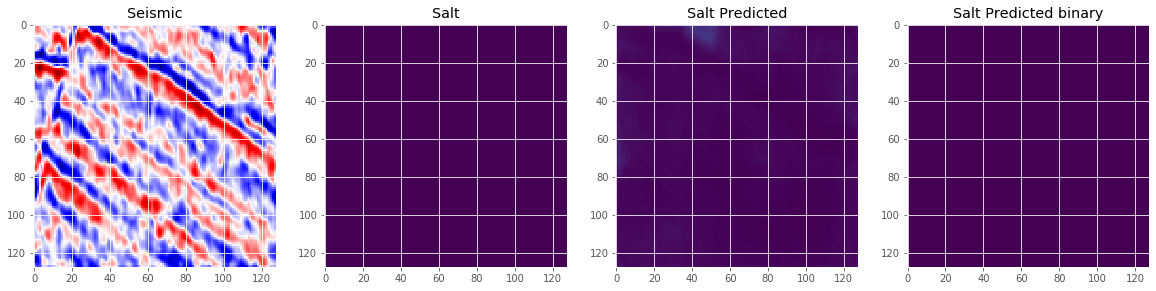

In [49]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

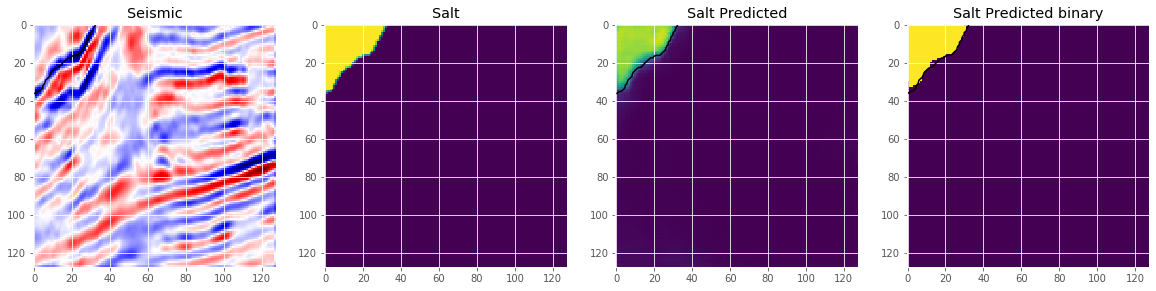

In [50]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

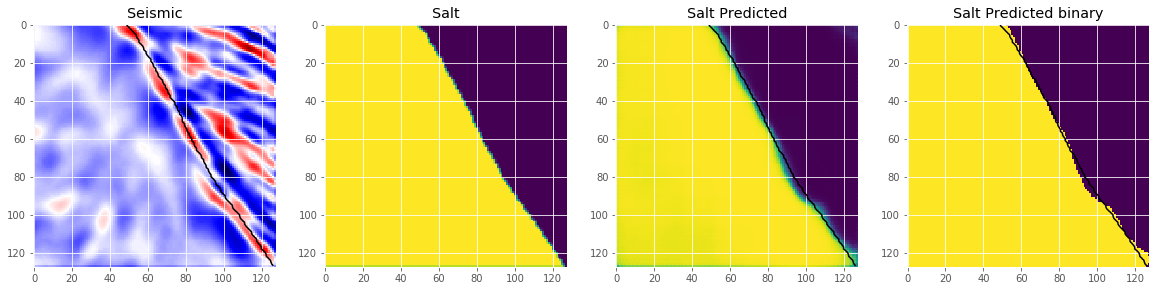

In [51]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)